# CIA World Factbook Analysis via SQLite3 

The CIA World Factbook is a collection of information on 267 world entities, though mainly countries and nation states. The factbook includes information on georgraphy, population, demographics, military, energy, etc.

In this analysis, we will be working with a database file with factbook information primarily dealing with population, population growth, and land mass. We will be querying our database via sqlite3. 

Questions we will be trying to answer:

    1) Are there any outliers?
    2) Which countries are most densely populated?
    3) Which countries have more water than land mass?

## Initial Data Exploration

In [1]:
#import libraries
import sqlite3
import pandas as pd

#connect to database
conn = sqlite3.connect("factbook.db")

#query tables in database
q1 = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(q1, conn)

,type,name,tbl_name,rootpage,sql
0,table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"


In [2]:
#query all rows from table
q2 = "SELECT * FROM facts;"
pd.read_sql_query(q2, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230.0,652230.0,0.0,3.256434e+07,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748.0,27398.0,1350.0,3.029278e+06,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741.0,2381741.0,0.0,3.954217e+07,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468.0,468.0,0.0,8.558000e+04,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700.0,1246700.0,0.0,1.962535e+07,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072
5,6,ac,Antigua and Barbuda,442.0,442.0,0.0,9.243600e+04,1.24,15.85,5.69,2.21,2015-11-01 13:20:13.049627,2015-11-01 13:20:13.049627
6,7,ar,Argentina,2780400.0,2736690.0,43710.0,4.343189e+07,0.93,16.64,7.33,0.00,2015-11-01 13:20:18.233063,2015-11-01 13:20:18.233063
7,8,am,Armenia,29743.0,28203.0,1540.0,3.056382e+06,0.15,13.61,9.34,5.80,2015-11-01 13:20:23.048753,2015-11-01 13:20:23.048753
8,9,as,Australia,7741220.0,7682300.0,58920.0,2.275101e+07,1.07,12.15,7.14,5.65,2015-11-01 13:20:28.186341,2015-11-01 13:20:28.186341
9,10,au,Austria,83871.0,82445.0,1426.0,8.665550e+06,0.55,9.41,9.42,5.56,2015-11-01 13:20:33.093597,2015-11-01 13:20:33.093597


In [3]:
#query max and min values for extremities
q3 = '''
SELECT 
    min(population),
    max(population),
    min(population_growth),
    max(population_growth) 
FROM facts
'''

pd.read_sql_query(q3, conn)

,min(population),max(population),min(population_growth),max(population_growth)
0,0,7256490011,0.0,4.02


## Considering Outliers

From querying the minimum and maximum populations in our database, we see that there is a country with zero population and another with over 7 billion.

In [4]:
#look at countries with outlier populations
q4 = '''
SELECT 
    name,
    population 
FROM facts
WHERE 
    population == (SELECT min(population) FROM facts)
    OR 
    population == (SELECT max(population) FROM facts)
'''
pd.read_sql_query(q4,conn)

,name,population
0,Antarctica,0
1,World,7256490011


It seems like the "country" with zero population refers to Antartica, which would make sense since Antartica technically has no citizens. The outlier of 7 billion refers to the population of the world.

It subsequent queries, we will exclude these two entries.

## General Histograms 

To get a general sense of the data in the CIA Factbook database, we will take a look at how several statistics are distributed amongst the countries.

We will explore:
    
    1) Population Growth
    2) Population
    3) Birth Rate
    4) Death Rate
    5) Total Area

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1152b8c50>,
      dtype=object)

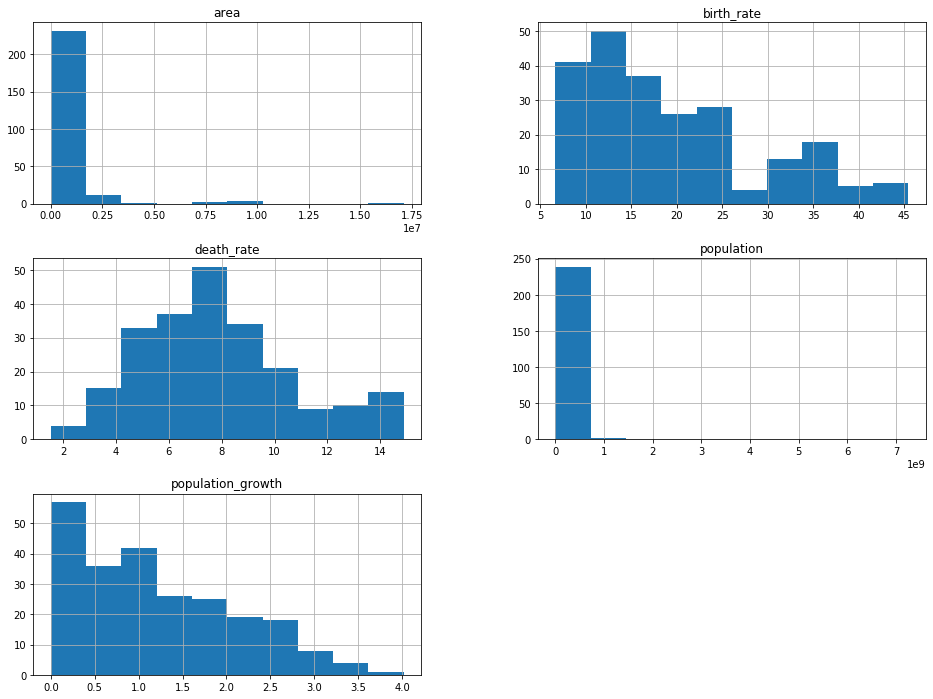

In [5]:
#import libraries
import matplotlib.pyplot as plt
%matplotlib inline

#suppress fig warning
import warnings
warnings.filterwarnings('ignore')

#create subplots
fig, ax = plt.subplots(figsize=(16,12))
#query different statistics - excluding World & Antartica
q5 = '''
SELECT 
    population,
    population_growth,
    birth_rate,
    death_rate,
    area
FROM facts
WHERE 
    name != 'World' 
    OR 
    name != 'Antartica'
'''
pd.read_sql_query(q5, conn).hist(ax=ax)

#### Initial Observations

From these quick histograms, there are a few things that can be noted. 

    1) In general, it seems that birth rates are generally much higher than death rates(expressed as births per 1000 people per year.
    2) The world population is growing.

Without knowing any other geographical, political, or general information on each country or region, it's quite hard to make any other practical observations.

## Highest Population Density

In [6]:
#query population to land ratio - excluding world & Antartica
q6 = '''
SELECT 
    name AS Country, 
    CAST(population AS float)/CAST(area_land AS float) AS Population_Density 
FROM facts
WHERE 
    name != 'World' 
    AND 
    name != 'Antartica'
ORDER BY Population_Density DESC
LIMIT 20
'''

pd.read_sql_query(q6, conn)

,Country,Population_Density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8259.784571
3,Hong Kong,6655.271202
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1158d2cf8>]],
      dtype=object)

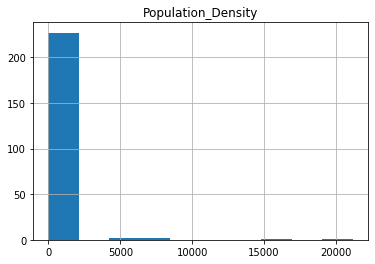

In [7]:
#Generate a Histogram of all densities
q7 = '''
SELECT 
    name AS Country, 
    CAST(population AS float)/CAST(area_land AS float) AS Population_Density 
FROM facts
WHERE name != 'World' AND name != 'Antartica'
'''

pd.read_sql_query(q7, conn).hist()

From the histogram above, it appears that most countries are not very densely populated.

## Highest Water to Land Ratio

In [8]:
#select countries where there's more water than land
q8 = '''
SELECT 
    name AS Country, 
    CAST(area_water AS float)/CAST(area_land AS float) AS Water_Land_Ratio 
FROM facts
ORDER BY Water_Land_Ratio DESC
Limit 20
'''

pd.read_sql_query(q8, conn)

,Country,Water_Land_Ratio
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
2,Puerto Rico,0.554791
3,"Bahamas, The",0.386613
4,Guinea-Bissau,0.284673
5,Malawi,0.259396
6,Netherlands,0.225710
7,Uganda,0.222922
8,Eritrea,0.164356
9,Liberia,0.156240


## Overall Observations

1) The 3 densest countries/regions are: 
 - Macau: $21,169\ persons\ per\ km^{2}$
 - Monaco: $15,268\ persons\ per\ km^{2}$
 - Singapore: $8,260\ persons\ per\ km^{2}$

2) The regions with more water than land mass are:
 - British Indian Ocean Territory: $906\ km^{2}\  water\ per\ km^{2}\ land$
 - Virgin Islands: $4.5\ km^{2}\  water\ per\ km^{2}\ land$